In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np
from collections import Counter
from konlpy.tag import Komoran
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 시각화 스타일 설정 (한글 폰트 설정 포함)
plt.rcParams['font.family'] = 'AppleGothic' # Mac 사용자
# plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 사용자
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

In [3]:
# ========= (1) 입력 경로 설정 =========
# 분석할 CSV 파일의 전체 경로를 입력하세요.
INPUT_CSV = "/Users/Shared/최종선_교수님/Face_skin_disease/데이터 전처리/피부 질환 화장품 데이터/여드름_스킨케어/크림/여드름_크림_reviews_flat.csv"

# 결과 파일이 저장될 경로 설정
SAVE_DIR = os.path.dirname(INPUT_CSV)
OUTPUT_CSV = os.path.join(SAVE_DIR, "Ntoken_review.csv")
print(f"입력 파일: {INPUT_CSV}")
print(f"저장될 파일: {OUTPUT_CSV}")


# ========= (2) 유틸리티 함수 정의 =========
def normalize_text(s: str) -> str:
    if pd.isna(s): return ""
    t = str(s).replace("\r\n","\n").replace("\r","\n").strip()
    t = re.sub(r"\n{3,}", "\n\n", t)
    return re.sub(r"[ ]{2,}", " ", t)

def parse_date_to_dot(s: str) -> str:
    if pd.isna(s) or not str(s).strip(): return ""
    dt = pd.to_datetime(str(s).strip(), errors="coerce")
    return str(s) if pd.isna(dt) else dt.strftime("%Y.%m.%d")

def to_float_safe(x):
    try: return float(str(x).strip())
    except Exception: return None

def extract_hangul(text: str) -> str:
    if pd.isna(text): return ""
    return re.sub(r"[^ ㄱ-ㅣ가-힣]+", " ", str(text)).strip()

print("\n✅ 경로 설정 및 유틸리티 함수 정의 완료")

입력 파일: /Users/Shared/최종선_교수님/Face_skin_disease/데이터 전처리/피부 질환 화장품 데이터/여드름_스킨케어/크림/여드름_크림_reviews_flat.csv
저장될 파일: /Users/Shared/최종선_교수님/Face_skin_disease/데이터 전처리/피부 질환 화장품 데이터/여드름_스킨케어/크림/Ntoken_review.csv

✅ 경로 설정 및 유틸리티 함수 정의 완료


In [4]:
# ========= (3) 로드 & 기본 정제 =========
def load_and_clean(input_path):
    # 파일 로드
    df = pd.read_csv(input_path, encoding="utf-8-sig")
    print(f"[로드] 행:{len(df)}")

    # 불필요 컬럼 제거
    for col in ["product_brand", "product_link", "rating_text"]:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    # 텍스트, 날짜, 평점 정리
    text_cols = ["product_name","customer_name","skin_type","skin_tone","skin_concerns","review","gender"]
    for c in text_cols:
        df[c] = df[c].apply(normalize_text)
    df["date"] = df["date"].apply(parse_date_to_dot)
    df["rating"] = df["rating"].apply(to_float_safe)
    
    # 리뷰 한글 추출 및 빈 리뷰 제거
    df["review"] = df["review"].apply(extract_hangul)
    df = df[df["review"].str.len() > 0].reset_index(drop=True)
    df["skin_type"] = df["skin_type"].apply(lambda x: "None" if (pd.isna(x) or str(x).strip()=="") else str(x))

    # 중복 제거
    before = len(df)
    df = df.drop_duplicates(subset=["product_name","customer_name","review"]).reset_index(drop=True)
    if before != len(df):
        print(f"[중복제거] {before-len(df)}건 제거 → {len(df)}건 남음")

    print(f"[정제 완료] 최종 데이터 크기: {df.shape}")
    return df

df = load_and_clean(INPUT_CSV)
df.head()

[로드] 행:12347
[중복제거] 522건 제거 → 11795건 남음
[정제 완료] 최종 데이터 크기: (11795, 9)


,product_name,customer_name,skin_type,skin_tone,skin_concerns,review,date,rating,gender
0,라로슈포제 시카플라스트 멀티 리페어 크림 100ml (+15ml+시카밤3ml+시카선...,vwaaang,건성,쿨톤,각질 / 모공,제품을 만난 이뢰로 계속 재구매중입니다 흡수가 빠르고 얼굴에 자고 일어나면 얼굴에 ...,2025.09.17,5.0,여성
1,라로슈포제 시카플라스트 멀티 리페어 크림 100ml (+15ml+시카밤3ml+시카선...,나이거가사로써도돼,건성,웜톤,민감성 / 트러블,아마도 수부지인 피부인데 이거 바르고 피부 다 뒤집어져서 한번 쓰고 바로 다른 잘맞...,2025.09.07,1.0,여성
2,라로슈포제 시카플라스트 멀티 리페어 크림 100ml (+15ml+시카밤3ml+시카선...,찍지말라옹,복합성,겨울쿨톤,각질 / 모공,와 정말 순하네요 가격이 쎄서 살까말까하다가 결국 샀는데 후회 도 없어요 저는 ...,2025.09.25,5.0,여성
3,라로슈포제 시카플라스트 멀티 리페어 크림 100ml (+15ml+시카밤3ml+시카선...,꿀피부촉촉,복합성,,,재재재구매 피부장벽 튼튼해집니다 트러블 관련 세럼에 이거 드음뿍 아낌없이 바릅니다...,2025.09.26,5.0,여성
4,라로슈포제 시카플라스트 멀티 리페어 크림 100ml (+15ml+시카밤3ml+시카선...,악악악악지성,지성,봄웜톤,각질 / 다크서클,극지성에 심각한 여드름 피부라 시어버터같은 여드름 유발하는 성분이나 모공막는 성분 ...,2025.10.01,3.0,여성


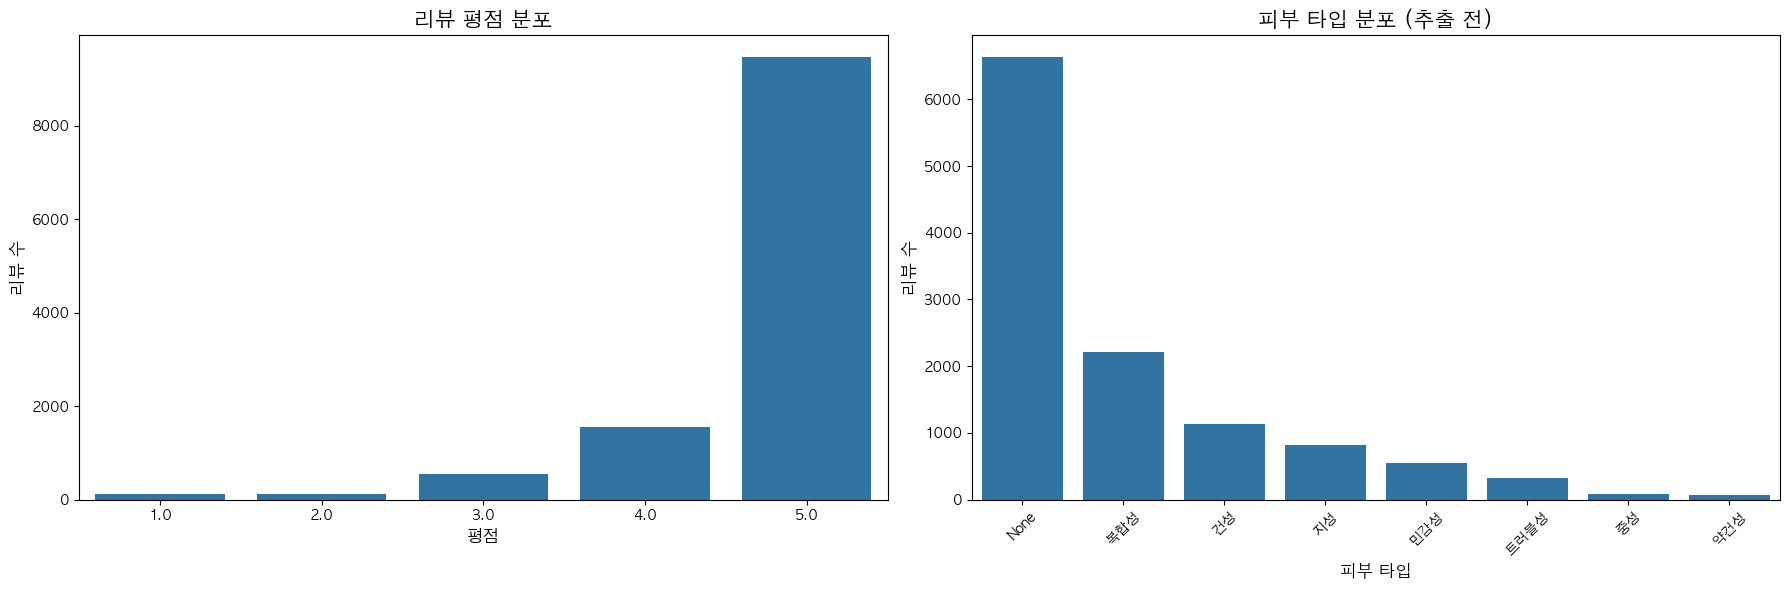

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 평점 분포 시각화
sns.countplot(ax=axes[0], x='rating', data=df, order=sorted(df['rating'].dropna().unique()))
axes[0].set_title('리뷰 평점 분포', fontsize=15)
axes[0].set_xlabel('평점', fontsize=12)
axes[0].set_ylabel('리뷰 수', fontsize=12)

# 피부 타입 분포 시각화
skin_type_counts = df['skin_type'].value_counts()
sns.barplot(ax=axes[1], x=skin_type_counts.index, y=skin_type_counts.values)
axes[1].set_title('피부 타입 분포 (추출 전)', fontsize=15)
axes[1].set_xlabel('피부 타입', fontsize=12)
axes[1].set_ylabel('리뷰 수', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

✅ 피부 타입 자동 추출 완료!


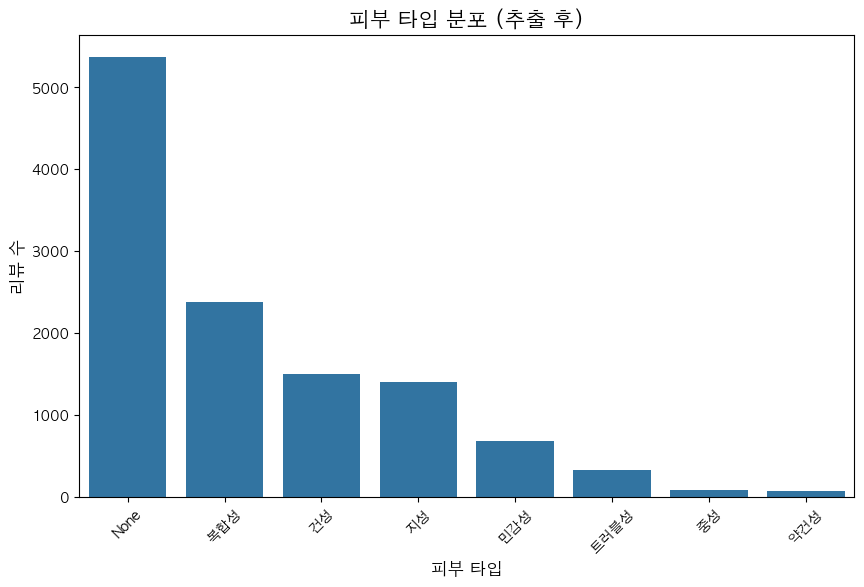

In [7]:
# ========= (4) 피부타입 자동 추출 =========
def advanced_skin_type_extraction(df: pd.DataFrame) -> pd.DataFrame:
    TYPE_GROUP = r"(건성|지성|복합성|민감성|수부지|약건성|중성|트러블성)"
    patterns = [re.compile(rf"{TYPE_GROUP}")]
    
    def extract_from_text(text):
        s = "" if pd.isna(text) else str(text)
        for p in patterns:
            m = p.search(s)
            if m:
                val = m.group(m.lastindex or 1)
                return "지성" if val == "수부지" else val
        return "None"

    # 'None' 값을 가진 행을 찾기 위한 마스크 - .str 접근자 추가
    mask = df["skin_type"].astype(str).str.strip().eq("None")
    
    # 마스크에 해당하는 행의 'review' 열에만 함수를 적용하여 'skin_type' 업데이트
    df.loc[mask, "skin_type"] = df.loc[mask, "review"].apply(extract_from_text)
    
    print("✅ 피부 타입 자동 추출 완료!")
    return df

df = advanced_skin_type_extraction(df)

# 추출 후 피부 타입 분포 시각화
plt.figure(figsize=(10, 6))
skin_type_counts_after = df['skin_type'].value_counts()
sns.barplot(x=skin_type_counts_after.index, y=skin_type_counts_after.values)
plt.title('피부 타입 분포 (추출 후)', fontsize=15)
plt.xlabel('피부 타입', fontsize=12)
plt.ylabel('리뷰 수', fontsize=12)
plt.xticks(rotation=45)
plt.show()

형태소 분석을 시작합니다 (데이터 양에 따라 시간이 소요될 수 있습니다)...
✅ 명사 토큰 추출 완료!


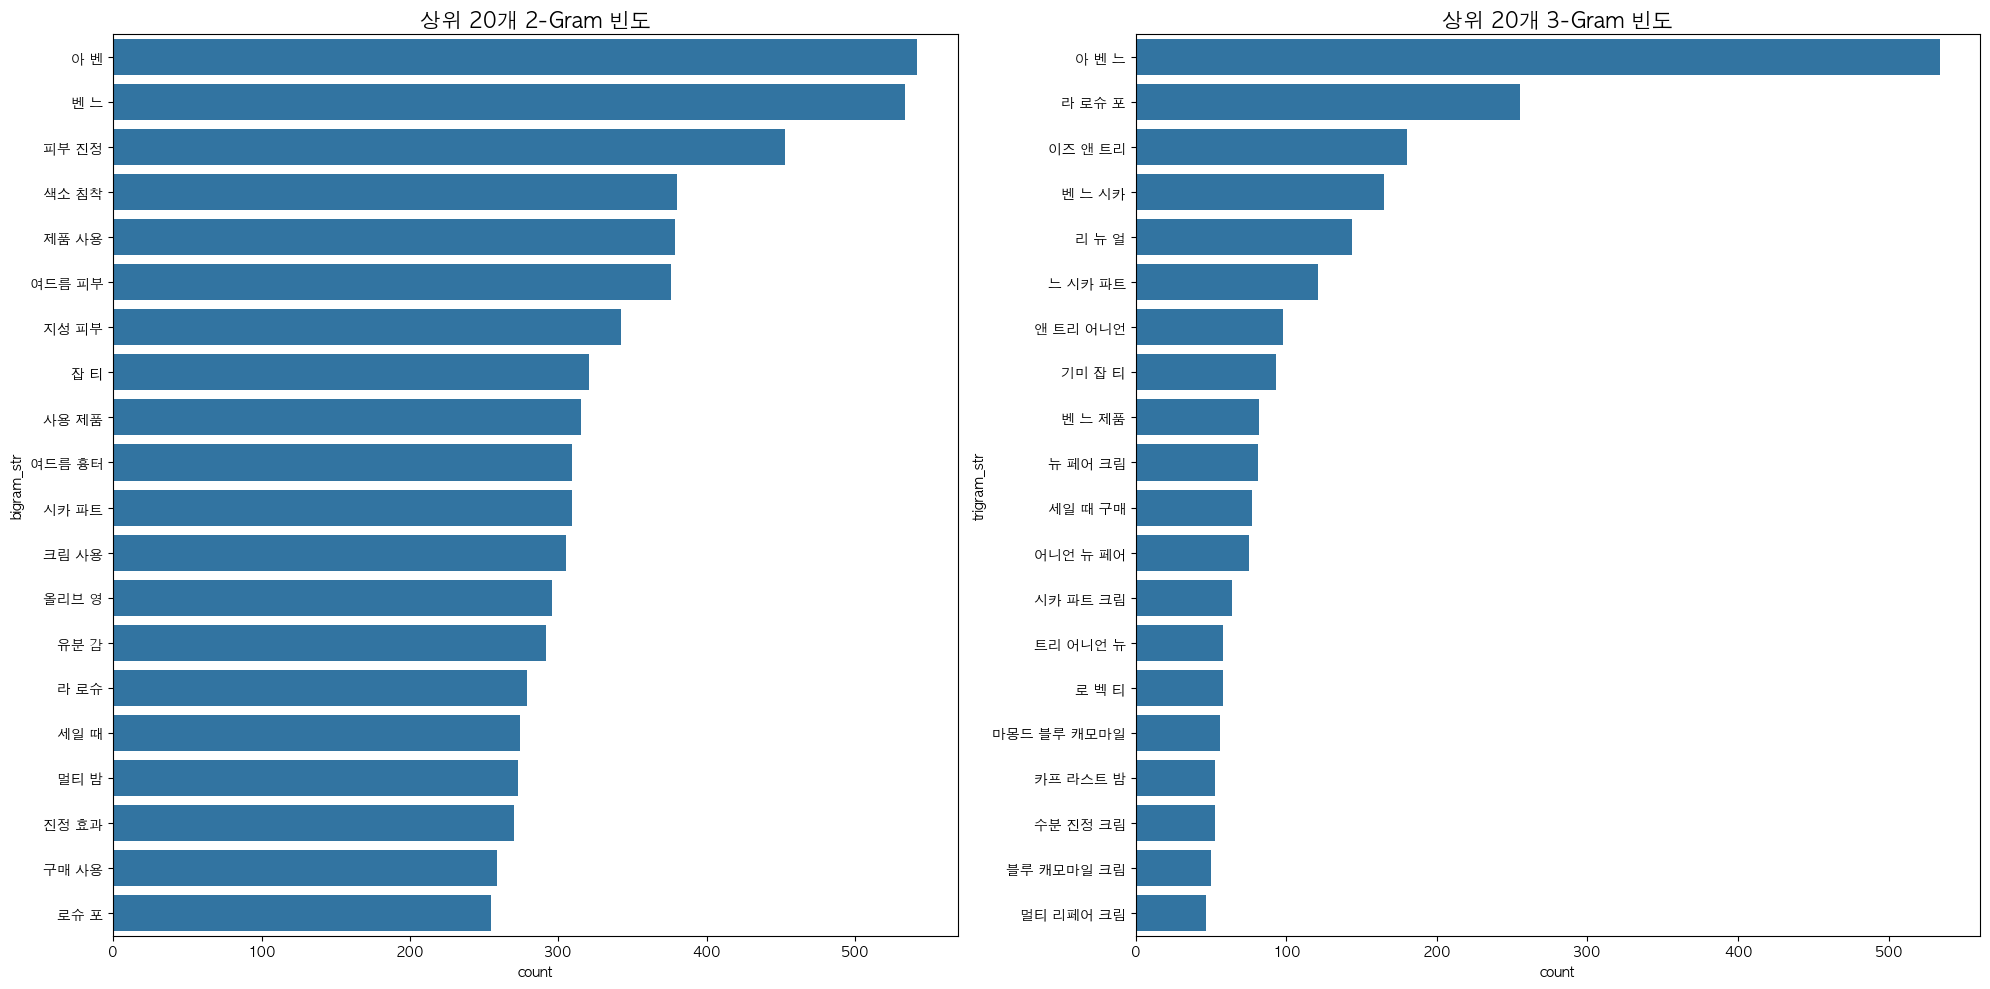

In [8]:
# ========= (5) 형태소 분석 → 명사 토큰 =========
# user_dict.txt가 노트북과 같은 경로에 있으면 사용자 사전을 로드합니다.
user_dict_path = './user_dict.txt'
komoran = Komoran(userdic=user_dict_path) if os.path.exists(user_dict_path) else Komoran()

print("형태소 분석을 시작합니다 (데이터 양에 따라 시간이 소요될 수 있습니다)...")
df["tokens_pos"] = df["review"].apply(lambda x: komoran.pos(x))

Ntag = {"NNP", "NNG"}
Ntoken_list = [[w for (w, tag) in toks if tag in Ntag] for toks in df["tokens_pos"]]
print("✅ 명사 토큰 추출 완료!")

# N-gram 생성 및 빈도 계산
bigram = [ (tokens[j], tokens[j+1]) for tokens in Ntoken_list for j in range(len(tokens)-1) ]
trigram = [ (tokens[j], tokens[j+1], tokens[j+2]) for tokens in Ntoken_list for j in range(len(tokens)-2) ]

bigram_df = pd.DataFrame(Counter(bigram).most_common(20), columns=['bigram', 'count'])
trigram_df = pd.DataFrame(Counter(trigram).most_common(20), columns=['trigram', 'count'])

# N-gram 시각화
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
bigram_df['bigram_str'] = bigram_df['bigram'].apply(lambda x: ' '.join(x))
sns.barplot(ax=axes[0], x='count', y='bigram_str', data=bigram_df)
axes[0].set_title('상위 20개 2-Gram 빈도', fontsize=15)

trigram_df['trigram_str'] = trigram_df['trigram'].apply(lambda x: ' '.join(x))
sns.barplot(ax=axes[1], x='count', y='trigram_str', data=trigram_df)
axes[1].set_title('상위 20개 3-Gram 빈도', fontsize=15)

plt.tight_layout()
plt.show()

In [10]:
# ========= (6) & (7) 단어 합성 및 불용어 제거 =========

# --- 단어 합성 ---
# 딕셔너리 생성 문법 오류를 수정했습니다.
patterns_3 = {tuple(p[0]): p[1] for p in [
    (['아','벤','느'],'아벤느'), (['리얼','베리','어'],'리얼베리어'), 
    (['수분','부족','지성'],'수부지'), (['피부','진정','효과'],'진정'), 
    (['민','감성','피부'],'민감성')
]}
# '좁쌀여름' -> '좁쌀여드름' 오타를 수정하고, 딕셔너리 문법 오류를 수정했습니다.
patterns_2 = {tuple(p[0]): p[1] for p in [
    (['수분','크림'],'수분크림'), (['수분','감'],'수분감'), 
    (['진정','효과'],'진정효과'), (['속','건조'],'속건조'), 
    (['좁쌀','여드름'],'좁쌀여드름') # '여름' -> '여드름' 수정
]}

def compound_words(tokens):
    # 3-gram
    i = 0
    while i < len(tokens) - 2:
        gram = tuple(tokens[i:i+3])
        if gram in patterns_3:
            tokens[i] = patterns_3[gram]
            del tokens[i+1:i+3]
        i += 1
    # 2-gram
    i = 0
    while i < len(tokens) - 1:
        gram = tuple(tokens[i:i+2])
        if gram in patterns_2:
            tokens[i] = patterns_2[gram]
            del tokens[i+1]
        i += 1
    return tokens

Ntoken_list = [compound_words(toks) for toks in Ntoken_list]
print("✅ 단어 합성 완료!")

# --- 불용어 제거 ---
stopwords_path = "./stopwords.txt"
sw = set()
if os.path.exists(stopwords_path):
    sw.update(pd.read_csv(stopwords_path, header=None)[0].astype(str).tolist())
add_sw = ['아벤느','리얼베리어','바이오힐보','라로슈포','올리브영']
sw.update(add_sw)

Ntoken_list = [[t for t in toks if (t not in sw and len(t) > 1)] for toks in Ntoken_list]
print("✅ 불용어 제거 완료!")

# 최종 결과 컬럼 추가
df["Ntoken_review"] = Ntoken_list
print("\n[전처리 전 리뷰 샘플]:", df['review'].iloc[0])
print("[전처리 후 토큰 샘플]:", df['Ntoken_review'].iloc[0])

✅ 단어 합성 완료!
✅ 불용어 제거 완료!

[전처리 전 리뷰 샘플]: 제품을 만난 이뢰로 계속 재구매중입니다 흡수가 빠르고 얼굴에 자고 일어나면 얼굴에 광이 돌아요 과한 유분기가 돌면 저는 무조건 여드름이 나는데  는 격하게 올리고 자도 한번도 여드름이 나지 않았어요  리뉴얼되면 울듯 ㅠ
[전처리 후 토큰 샘플]: ['제품', '구매', '흡수', '얼굴', '얼굴', '유분기', '여드름', '여드름']


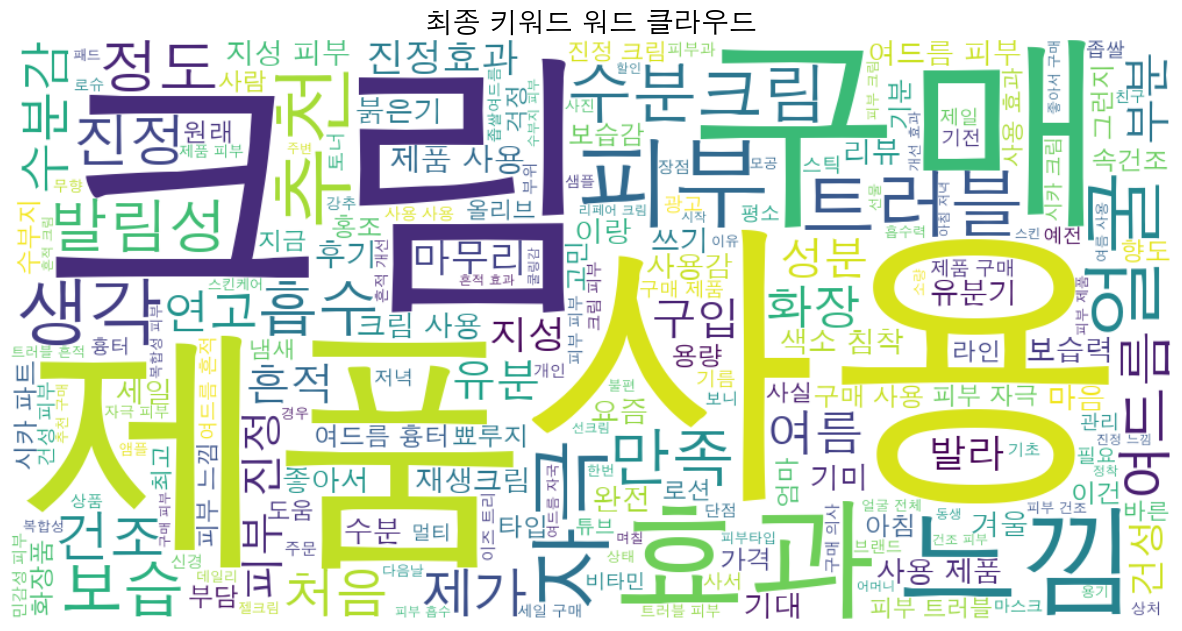


✅ 모든 작업 완료! 최종 결과가 /Users/Shared/최종선_교수님/Face_skin_disease/데이터 전처리/피부 질환 화장품 데이터/여드름_스킨케어/크림/Ntoken_review.csv 에 저장되었습니다.
최종 데이터 행 수: 11795


In [11]:
# ========= (8) 워드 클라우드 및 저장 =========
all_tokens = [token for sublist in df['Ntoken_review'] for token in sublist]

wordcloud = WordCloud(
    font_path='AppleGothic', # Mac 사용자
    # font_path='C:/Windows/Fonts/malgun.ttf', # Windows 사용자
    width=1000, height=500, background_color='white'
).generate(' '.join(all_tokens))

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('최종 키워드 워드 클라우드', fontsize=20)
plt.show()

# --- 최종 파일 저장 ---
df["tokens"] = df["tokens_pos"]
out_cols = ["product_name","customer_name","skin_type","skin_tone", "skin_concerns",
            "review","date","rating","gender", "tokens","Ntoken_review"]
out_cols = [c for c in out_cols if c in df.columns]

df[out_cols].to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")
print(f"\n✅ 모든 작업 완료! 최종 결과가 {OUTPUT_CSV} 에 저장되었습니다.")
print(f"최종 데이터 행 수: {len(df)}")